If needed, the hardcoded values and bounds in the following cell can be changed. The script assumes there is a file called data.npz which contains data headers: voltage, power and soc. We also assume time ticks are 1 second.

In [8]:
import numpy as np

data = np.load('data.npz')
U_measured = data['voltage']
power = np.array(data['power'], dtype=np.float64)
soc_measured = data['soc']

# Calculate current
I_load = power / U_measured  # Ensure U_measured has no zeros to avoid division errors

N = len(U_measured)  # Number of data points

# Hardcoded values
Q_total = 259200
max_current_capacity = 40
max_energy_capacity = 500
SOC_data = [0.0752, 0.1705, 0.2677, 0.366, 0.4654, 0.5666, 0.6701, 0.7767, 0.8865, 1.0]

# Bounds derived from conventional battery ranges
bounds = (
    [(0, 0.02)] * 10 +    # R_0_data (Ohmic Resistance)
    [(0, 0.05), (5000, 30000)] +  # R_P (Polarization Resistance), C_P (Capacitance)
    [(3.3, 4.3)] * 10   # Uoc_data (Open Circuit Voltage)
)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from physics.models.battery import BatteryModel, BatteryModelConfig

# Define the objective function
def objective(params, visualize=True, optimized=False):
    battery_config = BatteryModelConfig(
        R_0_data=params[:10],  # Optimized R_0_data
        R_P=params[10],        # Optimized R_P
        C_P=params[11],        # Optimized C_P
        Q_total=Q_total,
        SOC_data=SOC_data,     # Hardcoded SOC data
        Uoc_data=params[12:22],# Optimized Uoc_data
        max_current_capacity=max_current_capacity,
        max_energy_capacity=max_energy_capacity
    )
    bm = BatteryModel(battery_config)

    # Run update_array
    soc_array, U_predicted = bm.update_array(power, 1, rust=True)

    # Plot results if visualization is enabled
    if visualize:
        plot_results(soc_array, U_predicted, power, U_measured, optimized)

    # Error metric: Mean squared error between predicted and real voltage
    return np.mean((U_measured - U_predicted) ** 2)


0.012515, 0.007803, 0.007997, 0.004826, 0.016184, 0.007628, 0.018970, 0.015510, 0.014173, 0.000841, 0.048600, 10428.295570, 3.646234, 4.193608, 4.088049, 3.490452, 3.829664, 3.551521, 3.663668, 4.196413, 3.824330, 3.424264


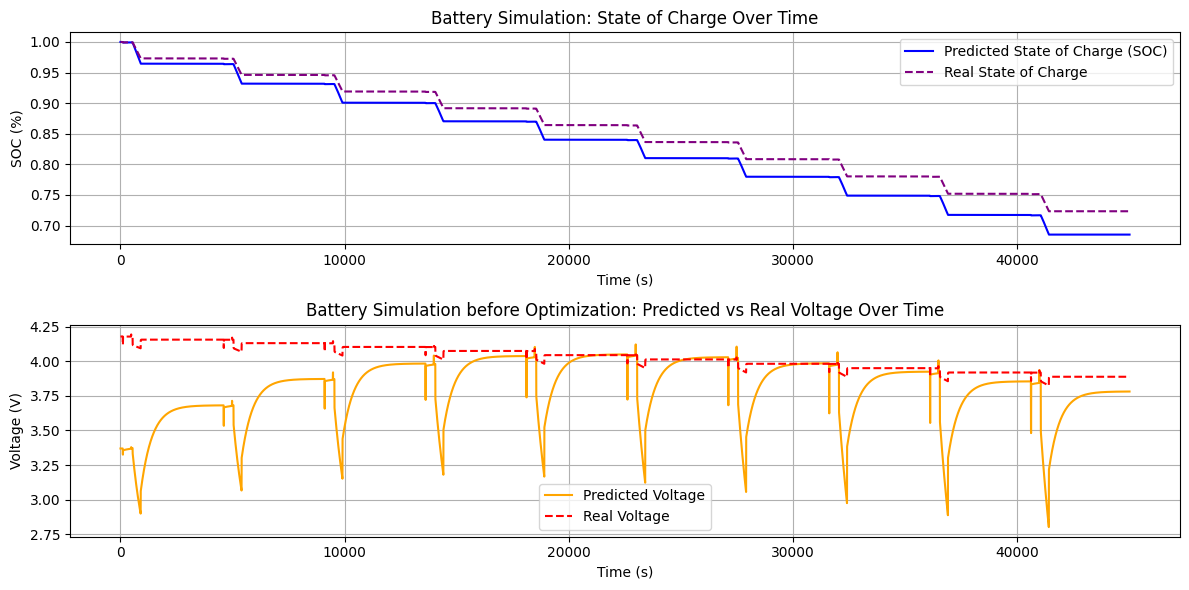

np.float64(0.1090632661557397)

In [15]:
# Function to plot objective function with initial guess
def plot_results(soc_array, voltage_array, power, U_measured, optimize):
    time = np.arange(len(power))

    plt.figure(figsize=(12, 6))

    # Plot SOC
    plt.subplot(2, 1, 1)
    plt.plot(time, soc_array, label="Predicted State of Charge (SOC)", color="blue")
    plt.plot(time, soc_measured, label="Real State of Charge", color="purple", linestyle="dashed")  # Real voltage added

    plt.xlabel("Time (s)")
    plt.ylabel("SOC (%)")
    if optimize:
        plt.title("Battery Simulation: Optimized State of Charge Over Time")
    else:
        plt.title("Battery Simulation: Unoptimized State of Charge Over Time")

    plt.grid(True)
    plt.legend()

    # Calculate min/max voltage values
    min_voltage = min(np.min(voltage_array), np.min(U_measured))
    max_voltage = max(np.max(voltage_array), np.max(U_measured))
    margin = (max_voltage - min_voltage) * 0.05  # 5% margin for visibility

    # Plot Voltage
    plt.subplot(2, 1, 2)
    plt.plot(time, voltage_array, label="Predicted Voltage", color="orange")
    plt.plot(time, U_measured, label="Real Voltage", color="red", linestyle="dashed")  # Real voltage added
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    if optimize:
        plt.title("Battery Simulation after Optimization: Predicted vs Real Voltage Over Time")
    else:
        plt.title("Battery Simulation before Optimization: Predicted vs Real Voltage Over Time")


    plt.ylim(min_voltage - margin, max_voltage + margin)  # Adjust Y-axis dynamically
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

perturbation_scale = 0.50  # 5% variation

initial_guess = np.array([np.random.uniform(low, high) for (low, high) in bounds])

print(", ".join([f"{x:.6f}" for x in initial_guess]))

# Run the objective function to visualize and print results
objective(initial_guess)


🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): 0.004365, 0.007235, 0.001007, 0.003800, 0.000674, 0.000056, 0.008483, 0.000635, 0.000868, 0.003508
- R_P (Polarization Resistance): 0.000591
- C_P (Capacitance): 12915.388277
- Uoc_data (Open Circuit Voltage): 3.919267, 3.389187, 4.043231, 3.640971, 3.708764, 3.647276, 3.723248, 4.224866, 3.922883, 4.202337

🔹 Final Voltage Error (MSE): 1.122139661664e-09



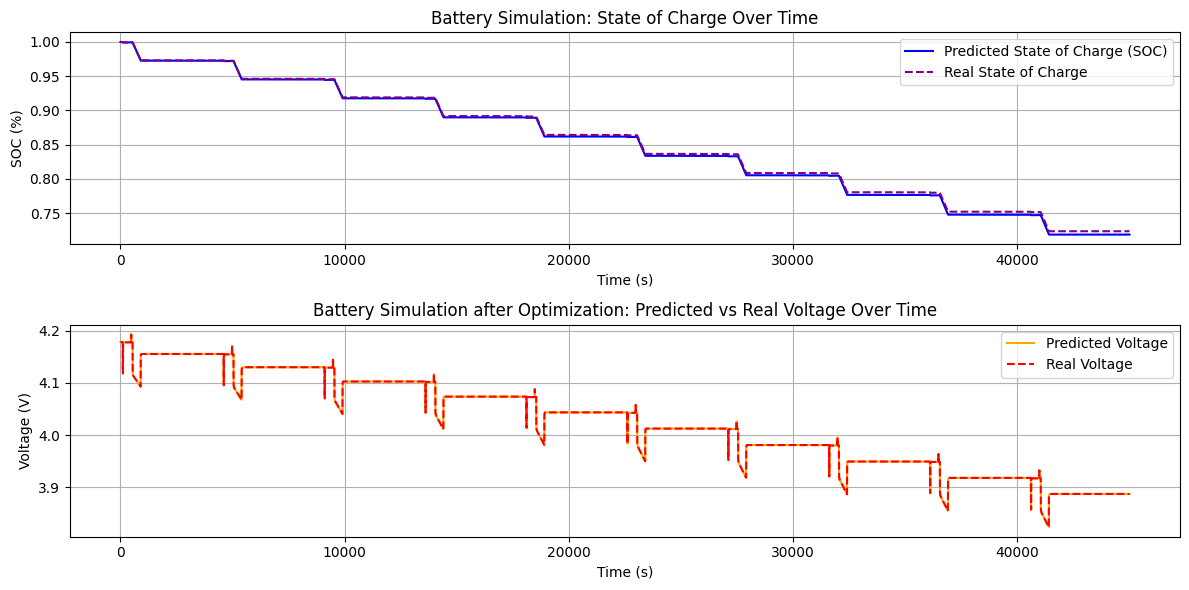

In [19]:
from scipy.optimize import minimize

# Define the optimization wrapper function
def optimization_wrapper(params):
    return objective(params, visualize=False)  # Run without plotting for efficiency

# Perform optimization using SciPy's minimize Powell method
result = minimize(optimization_wrapper, initial_guess, method='Powell', bounds=bounds)

# Optimized Parameters (Formatted with Data Labels)
optimized_params = result.x

formatted_params = f"""
🔹 Optimized Parameters:
- R_0_data (Ohmic Resistance): {", ".join([f"{x:.6f}" for x in optimized_params[:10]])}
- R_P (Polarization Resistance): {optimized_params[10]:.6f}
- C_P (Capacitance): {optimized_params[11]:.6f}
- Uoc_data (Open Circuit Voltage): {", ".join([f"{x:.6f}" for x in optimized_params[12:]])}

🔹 Final Voltage Error (MSE): {result.fun:.12e}
"""

print(formatted_params)

# Visualize the optimized model
# Run the model with optimized parameters and get predicted voltage
U_pred= objective(result.x, visualize=True, optimized=True)
